In [7]:
import numpy as np
import random
from accelerate import Accelerator
from utils import *
import grpo_utils 
from utils import load_peft_model, load_tokenizer, get_dataloader, left_pad, load_model

model_name = "../SmolLM-135M"
batch_size = 1
n_rollouts = 3
buffer_size = 6
max_new_tokens = 100

# load essentials
llm = load_peft_model(model_name) # For full finetuning

# llm = load_peft_model(model_name) # For only lora weights training
tokenizer = load_tokenizer(model_name)

dataloader = get_dataloader("syllogism", tokenizer)

optimizer = torch.optim.Adam(llm.parameters(), lr=1e-5)

# Initialize accelerator
accelerator = Accelerator()
llm, tokenizer, dataloader, optimizer = accelerator.prepare(
    llm, tokenizer, dataloader, optimizer
)


trainable params: 9,768,960 || all params: 144,283,968 || trainable%: 6.7706


In [2]:
llm.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 576,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 9,
  "num_hidden_layers": 30,
  "num_key_value_heads": 3,
  "pad_token_id": 2,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "vocab_size": 49152
}

In [8]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['validator', 'inputs'])

In [3]:
print(batch)

{'validator': [{'question': 'Consider these statements:\n1. No students are humans\n2. All humans are chefs\n\nDoes it logically follow that:\nSome chefs are humans?\n(Answer Yes or No)', 'answer': 'Yes', 'metadata': {'source_dataset': 'syllogism', 'source_index': 0, 'premise1': 'No students are humans', 'premise2': 'All humans are chefs', 'selected_premise': 2, 'conclusion': 'Some chefs are humans', 'is_valid': True, 'type': 'inversion'}}, {'question': 'Consider these statements:\n1. All children are animals\n2. Some animals are not doctors\n\nDoes it logically follow that:\nSome children are not doctors?\n(Answer Yes or No)', 'answer': 'Yes', 'metadata': {'source_dataset': 'syllogism', 'source_index': 1, 'premise1': 'All children are animals', 'premise2': 'Some animals are not doctors', 'conclusion': 'Some children are not doctors', 'is_valid': True, 'type': 'syllogism'}}], 'inputs': {'input_ids': tensor([[    2,     2,     1,  9690,   198,   198,    49,  6634,   826, 11122,
        

In [16]:
batch["inputs"]["attention_mask"]

tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [17]:
print(tokenizer.decode(batch["inputs"]["input_ids"][0]))

<|im_end|><|im_end|><|im_start|>system

A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>.

Do not generate new code. Do not write python code.

You may also be given examples by the user telling you the expected response format.
Follow the format of the examples, but solve the specific problem asked by the user, not the examples.

Very important - Remember again, your output format should be:
<think> reasoning process here </think>
<answer> answer here </answer>

Your response will be scored by extracting the substring between the <answer>...</answer> tags.
It is critical to follow the above format.
feature_extraction_utilsling to follow the 

In [7]:
print(tokenizer.batch_decode(batch["inputs"]["input_ids"])[0])

<|im_end|><|im_end|><|im_start|>system

A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>.

Do not generate new code. Do not write python code.

You may also be given examples by the user telling you the expected response format.
Follow the format of the examples, but solve the specific problem asked by the user, not the examples.

Very important - Remember again, your output format should be:
<think> reasoning process here </think>
<answer> answer here </answer>

Your response will be scored by extracting the substring between the <answer>...</answer> tags.
It is critical to follow the above format.
feature_extraction_utilsling to follow the 

In [8]:
print(batch["validator"][1])

{'question': 'Consider these statements:\n1. All children are animals\n2. Some animals are not doctors\n\nDoes it logically follow that:\nSome children are not doctors?\n(Answer Yes or No)', 'answer': 'Yes', 'metadata': {'source_dataset': 'syllogism', 'source_index': 1, 'premise1': 'All children are animals', 'premise2': 'Some animals are not doctors', 'conclusion': 'Some children are not doctors', 'is_valid': True, 'type': 'syllogism'}}


# Data Collection Step

In [40]:
llm, tokenizer, dataloader, optimizer = llm, tokenizer, dataloader, optimizer

batch = next(iter(dataloader))

input_ids = batch["inputs"]["input_ids"]


attention_mask = batch["inputs"]["attention_mask"]
validator = batch["validator"]
input_size = input_ids.shape[1]


with torch.no_grad():
    full_responses = llm.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens, # 100
        do_sample=True,
        top_p=0.95,
        num_return_sequences=n_rollouts,
        temperature=1,
        eos_token_id=tokenizer.eos_token_id,
    )
    
    assistant_responses = full_responses[:, input_size:]

    # Calculate the logits for each selected tokens
    log_probs = grpo_utils.calculate_logits(llm, full_responses, attention_mask)

    # Convert tokens to string
    decoded_responses = tokenizer.batch_decode(
        assistant_responses, skip_special_tokens=True
    )

    # model_responses = [batch_size*n_rollouts, max_new_tokens]
    rewards, format_rewards, correctness_rewards = grpo_utils.calculate_rewards(
        decoded_responses, np.repeat(validator, n_rollouts)
    )

    # advantages = [batch_size, n_rollouts]
    rewards = np.reshape(rewards, [2, n_rollouts])
    advantages = (rewards - np.mean(rewards, axis=1, keepdims=True)) / (
        np.std(rewards, axis=1, keepdims=True) + 1e-8
    )

    advantages = advantages.reshape(-1, 1)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(llm.device)

    padded_tokens = (full_responses != tokenizer.eos_token_id).int()
    response_start_idx = padded_tokens.argmax(axis=-1)
    response_end_idx = padded_tokens.shape[1] - torch.flip(
        padded_tokens, dims=[1]
    ).argmax(dim=1)

    response_mask = torch.zeros_like(padded_tokens)
    for i in range(len(response_mask)):
        response_mask[i, input_size : response_end_idx[i]] = 1
experience = [
    {
        "input_sequence": full_responses[
            i, response_start_idx[i] : response_end_idx[i]
        ],
        "log_probs": log_probs[i, response_start_idx[i] : response_end_idx[i]],
        "response_mask": response_mask[
            i, response_start_idx[i] : response_end_idx[i]
        ],
        "advantages": advantages[i],
    }
    for i in range(advantages.shape[0])
]


Format rewards: [1. 1. 1. 1. 1. 1.]
Correctness rewards: [1. 1. 1. 0. 1. 0.]
Combined rewards: [1.   1.   1.   0.15 1.   0.15]


In [6]:
full_responses.shape

torch.Size([6, 385])

In [8]:
print(tokenizer.batch_decode(full_responses, skip_special_tokens=True)[0])

system

A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>.

Do not generate new code. Do not write python code.

You may also be given examples by the user telling you the expected response format.
Follow the format of the examples, but solve the specific problem asked by the user, not the examples.

Very important - Remember again, your output format should be:
<think> reasoning process here </think>
<answer> answer here </answer>

Your response will be scored by extracting the substring between the <answer>...</answer> tags.
It is critical to follow the above format.
feature_extraction_utilsling to follow the response format will result in a

In [10]:
validator[1]

{'question': 'Consider these statements:\n1. All children are animals\n2. Some animals are not doctors\n\nDoes it logically follow that:\nSome children are not doctors?\n(Answer Yes or No)',
 'answer': 'Yes',
 'metadata': {'source_dataset': 'syllogism',
  'source_index': 1,
  'premise1': 'All children are animals',
  'premise2': 'Some animals are not doctors',
  'conclusion': 'Some children are not doctors',
  'is_valid': True,
  'type': 'syllogism'}}

In [18]:
assistant_responses = full_responses[:, input_size:]
assistant_responses = tokenizer.batch_decode(assistant_responses,skip_special_tokens=True)
print(assistant_responses[0])

<think>From the premises: "No students are humans" means no students are humans, which does not necessarily mean any students are humans. "All humans are chefs" says there is at least one chef in each of the humans. "In fact, no other group of humans could be outside the category of chefs because humans and chefs overlap, which means the set of chefs must be a subset of humans." Therefore, the conclusion "Some chefs are humans" logically follows because the "some"


In [23]:
print(rewards)


[0.0225 0.0225 1.     0.0225 1.     0.0225]


In [24]:
print(f"input_ids.shape: {input_ids.shape}")
print(f"full_responses.shape: {full_responses.shape}")
print(f"len(decoded_responses): {len(decoded_responses)}")
print(f"validator: {validator}")  # Should be 1 element if batch size = 1
print(f"np.repeat(validator, n_rollouts): {np.repeat(validator, n_rollouts)}")


input_ids.shape: torch.Size([2, 285])
full_responses.shape: torch.Size([6, 385])
len(decoded_responses): 6
validator: [{'question': 'Consider these statements:\n1. No students are humans\n2. All humans are chefs\n\nDoes it logically follow that:\nSome chefs are humans?\n(Answer Yes or No)', 'answer': 'Yes', 'metadata': {'source_dataset': 'syllogism', 'source_index': 0, 'premise1': 'No students are humans', 'premise2': 'All humans are chefs', 'selected_premise': 2, 'conclusion': 'Some chefs are humans', 'is_valid': True, 'type': 'inversion'}}, {'question': 'Consider these statements:\n1. All children are animals\n2. Some animals are not doctors\n\nDoes it logically follow that:\nSome children are not doctors?\n(Answer Yes or No)', 'answer': 'Yes', 'metadata': {'source_dataset': 'syllogism', 'source_index': 1, 'premise1': 'All children are animals', 'premise2': 'Some animals are not doctors', 'conclusion': 'Some children are not doctors', 'is_valid': True, 'type': 'syllogism'}}]
np.repea

In [20]:
grpo_utils.extract_answer(decoded_responses[2])

'Yes'

In [27]:
# advantages = [batch_size, n_rollouts]
rewards = np.reshape(rewards, [2, n_rollouts])
advantages = (rewards - np.mean(rewards, axis=1, keepdims=True)) / (
    np.std(rewards, axis=1, keepdims=True) + 1e-8
)

print(advantages)

[[-0.70710677 -0.70710677  1.41421353]
 [-0.70710677  1.41421353 -0.70710677]]


In [28]:
advantages.mean(axis=1)

array([0., 0.])

In [29]:
advantages.std(axis=1)

array([0.99999998, 0.99999998])

In [41]:
response_mask[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [45]:
print(experience.keys())  # Output: ['name', 'age', 'city']

AttributeError: 'list' object has no attribute 'keys'

In [46]:
type(experience)

list

In [ ]:
experience = [
    {"input_sequence": full_responses[i, response_start_idx[i] : response_end_idx[i]],
     "log_probs": log_probs[i, response_start_idx[i] : response_end_idx[i]],
     "response_mask": response_mask[i, response_start_idx[i] : response_end_idx[i]],
     "advantages": advantages[i],
    }
    for i in range(advantages.shape[0])
]

In [49]:
experience[0].keys()

dict_keys(['input_sequence', 'log_probs', 'response_mask', 'advantages'])

## Training Step

Run this block a couple of times and you should see the loss go down!
If it doesn't, decrease the learning rate.

In [67]:

full_sequence = left_pad([b["input_sequence"] for b in experience]).to(
    accelerator.device
)
attention_mask = left_pad(
    [torch.ones_like(b["input_sequence"]) for b in experience], 0
).to(accelerator.device)
old_log_probs = left_pad([b["log_probs"] for b in experience]).to(accelerator.device)
response_mask = left_pad([b["response_mask"] for b in experience]).to(accelerator.device)

advantages = (
    torch.cat([b["advantages"] for b in experience], dim=0)
    .unsqueeze(-1)
    .to(accelerator.device)
)

log_probs = grpo_utils.calculate_logits(llm, full_sequence, attention_mask)

loss = grpo_utils.calculate_grpo_loss(
    log_probs=log_probs,
    old_log_probs=old_log_probs,
    response_mask=response_mask,
    advantages=advantages,
)
print(loss)

accelerator.backward(loss)
optimizer.step()
optimizer.zero_grad()



tensor(-0.0093, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
for batch in dataloader:
    input_ids = batch["inputs"]["input_ids"]
    attention_mask = batch["inputs"]["attention_mask"]
    validator = batch["validator"]
    batch_size = input_ids.shape[0]
    input_size = input_ids.shape[1]

    with torch.no_grad():
        full_responses = llm.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,  # 100
            do_sample=True,
            top_p=0.95,
            num_return_sequences=n_rollouts,
            temperature=1,
            eos_token_id=tokenizer.eos_token_id,
        )
        assistant_responses = full_responses[:, input_size:]

        # Calculate logits etc.
        log_probs = grpo_utils.calculate_logits(llm, full_responses, attention_mask)

        decoded_responses = tokenizer.batch_decode(
            assistant_responses, skip_special_tokens=True
        )

        # Repeat validator for n_rollouts times per input
        rewards = grpo_utils.calculate_rewards(
            decoded_responses, np.repeat(validator, n_rollouts)
        )

        rewards = np.reshape(rewards, [batch_size, n_rollouts])
        advantages = (rewards - np.mean(rewards, axis=1, keepdims=True)) / (
            np.std(rewards, axis=1, keepdims=True) + 1e-8
        )
        advantages = advantages.reshape(-1, 1)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(llm.device)

        padded_tokens = (full_responses != tokenizer.eos_token_id).int()
        response_start_idx = padded_tokens.argmax(axis=-1)
        response_end_idx = padded_tokens.shape[1] - torch.flip(
            padded_tokens, dims=[1]
        ).argmax(dim=1)

        response_mask = torch.zeros_like(padded_tokens)
        for i in range(len(response_mask)):
            response_mask[i, input_size : response_end_idx[i]] = 1

        experience = [
            {
                "input_sequence": full_responses[
                    i, response_start_idx[i] : response_end_idx[i]
                ],
                "log_probs": log_probs[i, response_start_idx[i] : response_end_idx[i]],
                "response_mask": response_mask[
                    i, response_start_idx[i] : response_end_idx[i]
                ],
                "advantages": advantages[i],
            }
            for i in range(advantages.shape[0])
        ]

    # Cell 2 logic inside loop
    full_sequence = left_pad([b["input_sequence"] for b in experience]).to(accelerator.device)
    attention_mask = left_pad([torch.ones_like(b["input_sequence"]) for b in experience], 0).to(accelerator.device)
    old_log_probs = left_pad([b["log_probs"] for b in experience]).to(accelerator.device)
    response_mask = left_pad([b["response_mask"] for b in experience]).to(accelerator.device)
    advantages = torch.cat([b["advantages"] for b in experience], dim=0).unsqueeze(-1).to(accelerator.device)

    log_probs = grpo_utils.calculate_logits(llm, full_sequence, attention_mask)

    loss = grpo_utils.calculate_grpo_loss(
        log_probs=log_probs,
        old_log_probs=old_log_probs,
        response_mask=response_mask,
        advantages=advantages,
    )
    print(loss)

    accelerator.backward(loss)
    optimizer.step()
    optimizer.zero_grad()


tensor(-0.0604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3762, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.7607, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0590, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8085, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0176, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(58.1063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9072, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0280, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.9230, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0522, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.1451, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0770, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(22.2942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0288, devic

In [ ]:
import os

num_epochs = 5  # set how many epochs you want
log_file = "training_log.txt"
model_save_path = "./saved_model"

# Create folder if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

training_losses = []

with open(log_file, "w") as f_log:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        f_log.write(f"Epoch {epoch + 1}/{num_epochs}\n")

        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            validator = batch["validator"]
            batch_size = input_ids.shape[0]
            input_size = input_ids.shape[1]

            with torch.no_grad():
                full_responses = llm.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=max_new_tokens,  # 100
                    do_sample=True,
                    top_p=0.95,
                    num_return_sequences=n_rollouts,
                    temperature=1,
                    eos_token_id=tokenizer.eos_token_id,
                )
                assistant_responses = full_responses[:, input_size:]

                # Calculate logits etc.
                log_probs = grpo_utils.calculate_logits(llm, full_responses, attention_mask)

                decoded_responses = tokenizer.batch_decode(
                    assistant_responses, skip_special_tokens=True
                )

                rewards = grpo_utils.calculate_rewards(
                    decoded_responses, np.repeat(validator, n_rollouts)
                )

                rewards = np.reshape(rewards, [batch_size, n_rollouts])
                advantages = (rewards - np.mean(rewards, axis=1, keepdims=True)) / (
                    np.std(rewards, axis=1, keepdims=True) + 1e-8
                )
                advantages = advantages.reshape(-1, 1)
                advantages = torch.tensor(advantages, dtype=torch.float32).to(llm.device)

                padded_tokens = (full_responses != tokenizer.eos_token_id).int()
                response_start_idx = padded_tokens.argmax(axis=-1)
                response_end_idx = padded_tokens.shape[1] - torch.flip(
                    padded_tokens, dims=[1]
                ).argmax(dim=1)

                response_mask = torch.zeros_like(padded_tokens)
                for i in range(len(response_mask)):
                    response_mask[i, input_size : response_end_idx[i]] = 1

                experience = [
                    {
                        "input_sequence": full_responses[
                            i, response_start_idx[i] : response_end_idx[i]
                        ],
                        "log_probs": log_probs[i, response_start_idx[i] : response_end_idx[i]],
                        "response_mask": response_mask[
                            i, response_start_idx[i] : response_end_idx[i]
                        ],
                        "advantages": advantages[i],
                    }
                    for i in range(advantages.shape[0])
                ]

            full_sequence = left_pad([b["input_sequence"] for b in experience]).to(accelerator.device)
            attention_mask = left_pad([torch.ones_like(b["input_sequence"]) for b in experience], 0).to(accelerator.device)
            old_log_probs = left_pad([b["log_probs"] for b in experience]).to(accelerator.device)
            response_mask = left_pad([b["response_mask"] for b in experience]).to(accelerator.device)
            advantages = torch.cat([b["advantages"] for b in experience], dim=0).unsqueeze(-1).to(accelerator.device)

            log_probs = grpo_utils.calculate_logits(llm, full_sequence, attention_mask)

            loss = grpo_utils.calculate_grpo_loss(
                log_probs=log_probs,
                old_log_probs=old_log_probs,
                response_mask=response_mask,
                advantages=advantages,
            )

            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}")
            f_log.write(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}\n")
            f_log.flush()

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

# Save final model and tokenizer after training
print(f"Saving model to {model_save_path}")
llm.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


Epoch 1/5
Epoch 1, Batch 1, Loss: -0.0342
Epoch 1, Batch 2, Loss: 5.1182
Epoch 1, Batch 3, Loss: -0.0501
Epoch 1, Batch 4, Loss: -0.0354
Epoch 1, Batch 5, Loss: 0.2868
Epoch 1, Batch 6, Loss: 126.2230
Epoch 1, Batch 7, Loss: -0.0557
Epoch 1, Batch 8, Loss: -0.0503
Epoch 1, Batch 9, Loss: -0.0211
Epoch 1, Batch 10, Loss: 1.7522
Epoch 1, Batch 11, Loss: 208.6097
Epoch 1, Batch 12, Loss: 629.1606
Epoch 1, Batch 13, Loss: 0.5448
Epoch 1, Batch 14, Loss: 91.0846
Epoch 1, Batch 15, Loss: 1.6441
Epoch 1, Batch 16, Loss: 36.1148
Epoch 1, Batch 17, Loss: -0.0473
Epoch 1, Batch 18, Loss: 9.2348
Epoch 1, Batch 19, Loss: 1.2691
Epoch 1, Batch 20, Loss: -0.0451
Epoch 1, Batch 21, Loss: -0.0721
Epoch 1, Batch 22, Loss: 88.9724
Epoch 1, Batch 23, Loss: 0.9981
Epoch 1, Batch 24, Loss: -0.0566
Epoch 1, Batch 25, Loss: -0.0109
Epoch 1, Batch 26, Loss: 15.8651
Epoch 1, Batch 27, Loss: 18.2337
Epoch 1, Batch 28, Loss: 5.2963
Epoch 1, Batch 29, Loss: 5.0498
Epoch 1, Batch 30, Loss: -0.0084
Epoch 1, Batch 3

: 

# Visualization helper

In [68]:
import pandas as pd
def get_df(idx, clip_epsilon=1):
    num_tokens = 25
    importance_sampling_ratio = torch.exp(log_probs - old_log_probs)

    unclipped_ratio = importance_sampling_ratio
    clipped_ratio = torch.clamp(
        importance_sampling_ratio, 1 - clip_epsilon, 1 + clip_epsilon
    )

    clipped_loss = clipped_ratio * advantages
    unclipped_loss = unclipped_ratio * advantages

    loss = -torch.min(unclipped_loss, clipped_loss)
    tokens = [tokenizer.decode([token]) for token in full_sequence[idx, -num_tokens:]]
    df = pd.DataFrame(
        {
            "advantages": advantages[idx].item(),
            "old_log_probs": old_log_probs[idx, -num_tokens:].detach().cpu().float().numpy(),
            "log_probs": log_probs[idx, -num_tokens:].detach().cpu().float().numpy(),
            "ratio": importance_sampling_ratio[idx, -num_tokens:].detach().cpu().float().numpy(),
            "unclipped_ratio": unclipped_ratio[idx, -num_tokens:].detach().cpu().float().numpy(),
            f"clipped_ratio (eps={clip_epsilon})": clipped_ratio[idx, -num_tokens:].detach().cpu().float().numpy(),
            "unclipped_loss": unclipped_loss[idx, -num_tokens:].detach().cpu().float().numpy(),
            f"clipped_loss (eps={clip_epsilon})": clipped_loss[idx, -num_tokens:].detach().cpu().float().numpy(),
            "loss": loss[idx, -num_tokens:].detach().cpu().float().numpy(),
        }
    )
    df.index = tokens
    return df

In [14]:
df = get_df(0, clip_epsilon=0.2)
df

,advantages,old_log_probs,log_probs,ratio,unclipped_ratio,clipped_ratio (eps=0.2),unclipped_loss,clipped_loss (eps=0.2),loss
that,-0.707106,-9.562500,-9.187500,1.453125,1.453125,1.203125,-1.027514,-0.850737,1.027514
some,-0.707106,-15.687500,-16.375000,0.503906,0.503906,0.800781,-0.356315,-0.566237,0.566237
chefs,-0.707106,-23.250000,-23.125000,1.132812,1.132812,1.132812,-0.801019,-0.801019,0.801019
are,-0.707106,-14.562500,-14.437500,1.132812,1.132812,1.132812,-0.801019,-0.801019,0.801019
humans,-0.707106,-17.500000,-17.625000,0.882812,0.882812,0.882812,-0.624242,-0.624242,0.624242
.,-0.707106,-13.812500,-14.250000,0.644531,0.644531,0.800781,-0.455752,-0.566237,0.566237
\n,-0.707106,-0.259766,-0.207031,1.054688,1.054688,1.054688,-0.745776,-0.745776,0.745776
\n,-0.707106,-12.375000,-13.125000,0.472656,0.472656,0.800781,-0.334218,-0.566237,0.566237
Therefore,-0.707106,-23.875000,-23.750000,1.132812,1.132812,1.132812,-0.801019,-0.801019,0.801019
",",-0.707106,-14.687500,-14.312500,1.453125,1.453125,1.203125,-1.027514,-0.850737,1.027514


# Visualize log probs change

In [69]:
import matplotlib.pyplot as plt
import torch

def plot_log_probs(idx):
    gap = 4
    height = 1
    num_tokens = 25

    plt.figure(figsize=(6, 6))
    tokens = [tokenizer.decode([token]) for token in full_sequence[idx, -num_tokens:]]
    plt.barh(
        [gap*i for i in range(num_tokens)],
        log_probs[idx, -num_tokens:].detach().cpu().float().numpy(),
        label="log_probs",
        height=height,
    )
    plt.barh(
        [gap*i+1 for i in range(num_tokens)],
        old_log_probs[idx, -num_tokens:].detach().cpu().float().numpy(),
        label="old_log_probs",
        height=height,
    )
    plt.xlabel("log_probs")
    plt.yticks(range(0, gap*num_tokens, gap), reversed(tokens))
    plt.legend(loc='upper right')
    plt.title(f"Advantage: {advantages[idx].item():.2f}")

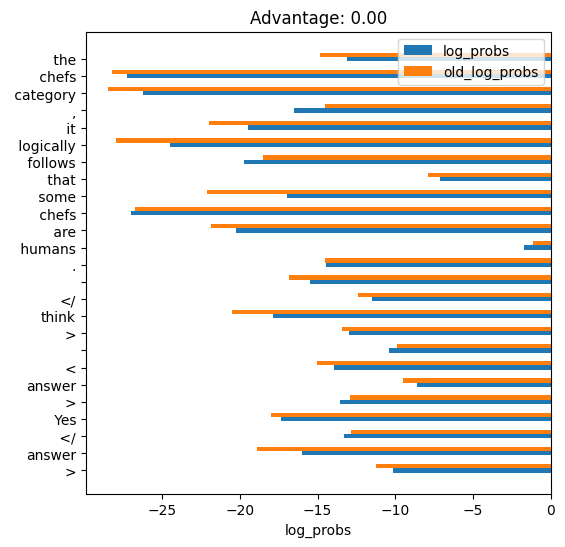

In [73]:

idx = 1
plot_log_probs(idx)

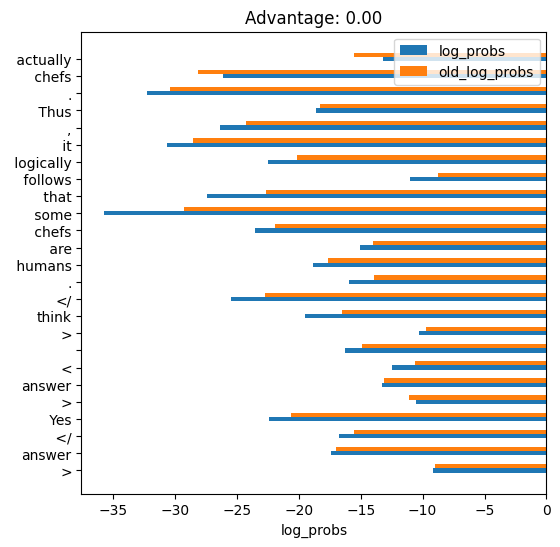

In [74]:
idx = 2
plot_log_probs(idx)

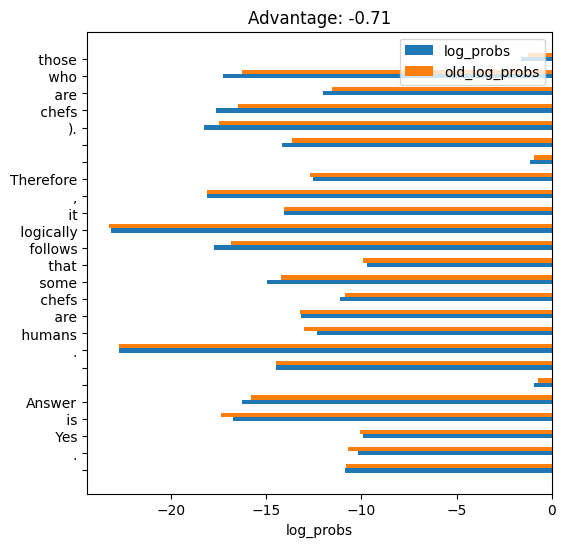

In [24]:
idx = 2
plot_log_probs(idx)

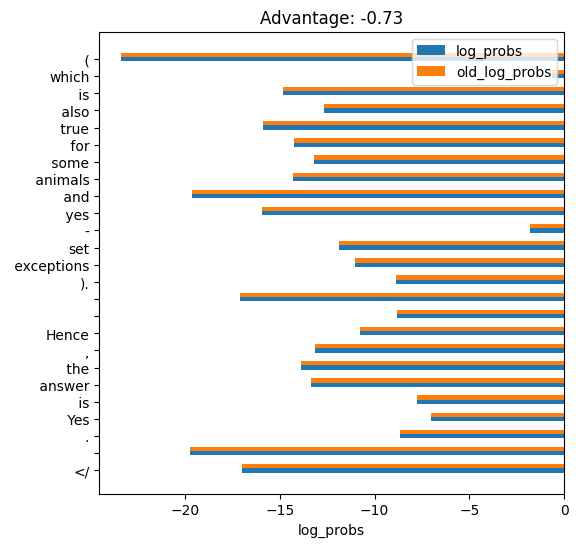

In [25]:
idx = 3
plot_log_probs(idx)

In [71]:
print(tokenizer.decode(full_sequence[idx], skip_special_tokens=False))

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|im_start|>system

A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>.

Do not generate new code. Do not write python code.

You may also be given examples by the user telling you the expected response format.
Follow the format of the examples, but solve the specific problem asked by the user, not the examples.


In [72]:
advantages[idx]

tensor([1.4142], device='cuda:0')

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import re

# === CONFIGURATION ===
model_path = "./saved_model"  # Path to your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example test prompts and expected answers
test_cases = [
    {
        "prompt": """Consider these statements:
1. No students are humans
2. All humans are chefs

Does it logically follow that:
Some chefs are humans?
(Answer Yes or No)""",
        "expected": "Yes"
    },
    {
        "prompt": """Consider these statements:
1. All mammals are warm-blooded.
2. Whales are mammals.

Does it logically follow that:
Whales are warm-blooded?
(Answer Yes or No)""",
        "expected": "Yes"
    },
    {
        "prompt": """Consider these statements:
1. All humans are mortal.
2. Socrates is a human.

Does it logically follow that:
Socrates is mortal?
(Answer Yes or No)""",
        "expected": "Yes"
    },
]

# === LOAD MODEL & TOKENIZER ===
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
model.eval()

# === HELPER FUNCTIONS ===

def format_prompt(prompt_text):
    """Format the prompt to match the model's expected structure."""
    return f"""<|im_start|>system
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively. Do not generate new code. Do not write python code.
<|im_end|>
<|im_start|>user
{prompt_text}
<|im_end|>
<|im_start|>assistant
"""

def extract_answer(text):
    """Extract the content within <answer>...</answer> tags."""
    match = re.search(r"<answer>(.*?)</answer>", text, re.DOTALL)
    return match.group(1).strip() if match else "N/A"

def generate_response(prompt_text):
    """Run inference and return formatted model output and extracted answer."""
    full_prompt = format_prompt(prompt_text)
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

    output = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=False,
        num_beams=1,
        repetition_penalty=1.2,
        length_penalty=0.8,
        eos_token_id=tokenizer.eos_token_id,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    # Remove the prompt part to get only the model's answer
    response = decoded[len(full_prompt):].strip()
    answer = extract_answer(response)
    return response, answer

# === RUN INFERENCE AND EVALUATE ===
correct = 0
total = len(test_cases)

print("\n=== MODEL RESPONSES ===\n")

for i, case in enumerate(test_cases, 1):
    prompt = case["prompt"]
    expected = case["expected"]
    response, answer = generate_response(prompt)

    print(f"Prompt {i}:\n{prompt}\n")
    print(f"<think> and <answer> Output:\n{response}\n")
    print(f"✅ Extracted Answer: {answer}")
    print(f"🎯 Expected Answer: {expected}")

    if expected.lower() in answer.lower():
        print("✅ Correct\n")
        correct += 1
    else:
        print("❌ Incorrect\n")

print(f"Final Accuracy: {correct}/{total} ({(100 * correct / total):.1f}%)")


Loading model and tokenizer...

=== MODEL RESPONSES ===

Prompt 1:
Consider these statements:
1. No students are humans
2. All humans are chefs

Does it logically follow that:
Some chefs are humans?
(Answer Yes or No)

<think> and <answer> Output:
there is no overlap between students and humans; "All humans are chefs" means all humans (including those who are included in the group of chefs) are also humans. Since no students are humans and all humans are chefs, some individuals who are included in the group of chefs must be human, so the conclusion "Some chefs are humans" follows.</think>
<answer> Yes }> Yes </answer> crosses the

✅ Extracted Answer: Yes }> Yes
🎯 Expected Answer: Yes
✅ Correct

Prompt 2:
Consider these statements:
1. All mammals are warm-blooded.
2. Whales are mammals.

Does it logically follow that:
Whales are warm-blooded?
(Answer Yes or No)

<think> and <answer> Output:
means all mammals (including whales) are warm-blooded. "Whales are Mating Partners of Mammals" me

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model = AutoModelForCausalLM.from_pretrained("./saved_model", torch_dtype=torch.bfloat16).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("./saved_model")

prompt = """A conversation between User and Assistant..."""  # same system_prompt

question = """Consider these statements:
1. All mammals are warm-blooded.
2. Whales are mammals.

Does it logically follow that:
Whales are warm-blooded?
(Answer Yes or No)"""

# Build input
chat_prompt = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": question}
]
input_text = tokenizer.apply_chat_template(chat_prompt, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

# Generate
output = model.generate(**inputs, max_new_tokens=100, do_sample=False)
decoded = tokenizer.decode(output[0], skip_special_tokens=True)

# Truncate at </answer>
if "</answer>" in decoded:
    decoded = decoded.split("</answer>")[0] + "</answer>"

print(decoded)


system
A conversation between User and Assistant...
user
Consider these statements:
1. All mammals are warm-blooded.
2. Whales are mammals.

Does it logically follow that:
Whales are warm-blooded?
(Answer Yes or No)
assistant
<pre>
From the premises:
1. All mammals are warm-blooded.
2. Whales are mammals.

From 2, whales are mammals.

Therefore, whales are warm-blooded.

Hence, "Whales are warm-blooded" is the correct answer.</pre>
<ocr>
    "From the premises:
       1. All mammals are warm-blooded.
       2. Wh whales are mammals.
       3. Therefore, whales


In [ ]:
import os
import torch
import numpy as np
from utils import load_peft_model, load_tokenizer, get_dataloader
import grpo_utils
from reasoning_gym import get_score_answer_fn
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def test_model():
    """
    Test the trained GRPO model on reasoning tasks
    """
    # Config - should match your training config
    model_save_path = "./saved_model"  # Path where you saved the trained model
    base_model_name = "../SmolLM-135M"  # Original base model for comparison
    test_datasets = ["syllogism"]  # Add more datasets as needed
    batch_size = 2
    max_new_tokens = 100
    n_test_samples = 50  # Number of samples to test on
    
    # Results storage
    results = {
        "trained_model": {},
        "base_model": {},
        "comparison": {}
    }
    
    print("=" * 60)
    print("GRPO MODEL TESTING")
    print("=" * 60)
    
    # Load trained model and tokenizer
    print("Loading trained model...")
    try:
        trained_model = load_peft_model(model_save_path)
        tokenizer = load_tokenizer(model_save_path)
        print("✓ Trained model loaded successfully")
    except Exception as e:
        print(f"✗ Error loading trained model: {e}")
        return
    
    # Load base model for comparison
    print("Loading base model for comparison...")
    try:
        base_model = load_peft_model(base_model_name)
        base_tokenizer = load_tokenizer(base_model_name)
        print("✓ Base model loaded successfully")
    except Exception as e:
        print(f"✗ Error loading base model: {e}")
        base_model = None
    
    # Test on each dataset
    for dataset_name in test_datasets:
        print(f"\n{'='*50}")
        print(f"Testing on dataset: {dataset_name}")
        print(f"{'='*50}")
        
        # Get test dataloader
        test_dataloader = get_dataloader(dataset_name, tokenizer, batch_size=batch_size)
        
        # Test trained model
        print("\nTesting trained model...")
        trained_results = evaluate_model(
            trained_model, tokenizer, test_dataloader, 
            max_new_tokens, n_test_samples, "Trained Model"
        )
        results["trained_model"][dataset_name] = trained_results
        
        # Test base model if available
        if base_model is not None:
            print("\nTesting base model...")
            base_results = evaluate_model(
                base_model, base_tokenizer, test_dataloader, 
                max_new_tokens, n_test_samples, "Base Model"
            )
            results["base_model"][dataset_name] = base_results
            
            # Compare results
            comparison = compare_models(trained_results, base_results, dataset_name)
            results["comparison"][dataset_name] = comparison
    
    # Save results
    save_results(results)
    
    # Generate plots
    if results["base_model"]:
        plot_comparison(results)
    
    print(f"\n{'='*60}")
    print("TESTING COMPLETED")
    print(f"{'='*60}")

def evaluate_model(model, tokenizer, dataloader, max_new_tokens, n_samples, model_name):
    """
    Evaluate a model on the given dataloader
    """
    model.eval()
    
    # Metrics storage
    format_rewards = []
    correctness_rewards = []
    total_rewards = []
    response_lengths = []
    samples_processed = 0
    sample_responses = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if samples_processed >= n_samples:
                break
                
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            validators = batch["validator"]
            
            print(f"  Processing batch {batch_idx + 1}...")
            
            # Generate responses
            try:
                full_responses = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    top_p=0.95,
                    temperature=0.7,  # Lower temperature for testing
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id,
                )
                
                # Extract only the generated part
                input_size = input_ids.shape[1]
                assistant_responses = full_responses[:, input_size:]
                
                # Decode responses
                decoded_responses = tokenizer.batch_decode(
                    assistant_responses, skip_special_tokens=True
                )
                
                # Calculate rewards for each response
                for i, (response, validator) in enumerate(zip(decoded_responses, validators)):
                    # Format reward
                    format_reward = grpo_utils.calculate_format_reward(response)
                    format_rewards.append(format_reward)
                    
                    # Correctness reward
                    extracted_answer = grpo_utils.extract_answer(response)
                    correctness_reward = grpo_utils.calculate_correctness_reward(response, validator)
                    correctness_rewards.append(correctness_reward)
                    
                    # Total reward
                    total_reward = (grpo_utils.FORMAT_REWARD_WEIGHT * format_reward + 
                                  grpo_utils.CORRECTNESS_REWARD_WEIGHT * correctness_reward)
                    total_rewards.append(total_reward)
                    
                    # Response length
                    response_lengths.append(len(response.split()))
                    
                    # Store sample for inspection
                    if len(sample_responses) < 5:  # Store first 5 samples
                        sample_responses.append({
                            "question": validator["question"],
                            "response": response,
                            "extracted_answer": extracted_answer,
                            "expected": validator.get("answer", "N/A"),
                            "format_reward": format_reward,
                            "correctness_reward": correctness_reward,
                            "total_reward": total_reward
                        })
                    
                    samples_processed += 1
                    if samples_processed >= n_samples:
                        break
                        
            except Exception as e:
                print(f"    Error in batch {batch_idx + 1}: {e}")
                continue
    
    # Calculate statistics
    results = {
        "model_name": model_name,
        "samples_processed": samples_processed,
        "avg_format_reward": np.mean(format_rewards),
        "avg_correctness_reward": np.mean(correctness_rewards), 
        "avg_total_reward": np.mean(total_rewards),
        "accuracy": np.mean([r > 0.5 for r in correctness_rewards]),
        "format_compliance": np.mean([r > 0.5 for r in format_rewards]),
        "avg_response_length": np.mean(response_lengths),
        "std_total_reward": np.std(total_rewards),
        "sample_responses": sample_responses,
        "all_rewards": {
            "format": format_rewards,
            "correctness": correctness_rewards,
            "total": total_rewards
        }
    }
    
    # Print results
    print(f"\n  Results for {model_name}:")
    print(f"    Samples processed: {samples_processed}")
    print(f"    Average total reward: {results['avg_total_reward']:.4f} ± {results['std_total_reward']:.4f}")
    print(f"    Accuracy: {results['accuracy']:.2%}")
    print(f"    Format compliance: {results['format_compliance']:.2%}")
    print(f"    Avg response length: {results['avg_response_length']:.1f} words")
    print(f"    Format reward: {results['avg_format_reward']:.4f}")
    print(f"    Correctness reward: {results['avg_correctness_reward']:.4f}")
    
    return results

def compare_models(trained_results, base_results, dataset_name):
    """
    Compare trained model vs base model results
    """
    print(f"\n  Comparison for {dataset_name}:")
    
    improvements = {
        "total_reward": trained_results['avg_total_reward'] - base_results['avg_total_reward'],
        "accuracy": trained_results['accuracy'] - base_results['accuracy'],
        "format_compliance": trained_results['format_compliance'] - base_results['format_compliance'],
    }
    
    print(f"    Total reward improvement: {improvements['total_reward']:+.4f}")
    print(f"    Accuracy improvement: {improvements['accuracy']:+.2%}")
    print(f"    Format compliance improvement: {improvements['format_compliance']:+.2%}")
    
    return improvements

def save_results(results):
    """
    Save results to JSON file
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"test_results_{timestamp}.json"
    
    # Convert numpy arrays to lists for JSON serialization
    json_results = {}
    for model_type, model_results in results.items():
        json_results[model_type] = {}
        for dataset, dataset_results in model_results.items():
            json_results[model_type][dataset] = {}
            for key, value in dataset_results.items():
                if isinstance(value, np.ndarray):
                    json_results[model_type][dataset][key] = value.tolist()
                elif isinstance(value, dict) and "all_rewards" in key:
                    json_results[model_type][dataset][key] = {
                        k: v.tolist() if isinstance(v, list) else v 
                        for k, v in value.items()
                    }
                else:
                    json_results[model_type][dataset][key] = value
    
    with open(filename, 'w') as f:
        json.dump(json_results, f, indent=2, default=str)
    
    print(f"\nResults saved to: {filename}")

def plot_comparison(results):
    """
    Create comparison plots
    """
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('GRPO Training Results Comparison', fontsize=16)
    
    for dataset_name in results["trained_model"].keys():
        trained = results["trained_model"][dataset_name]
        base = results["base_model"][dataset_name]
        
        # Plot 1: Reward comparison
        ax1 = axes[0, 0]
        categories = ['Total Reward', 'Accuracy', 'Format Compliance']
        trained_values = [trained['avg_total_reward'], trained['accuracy'], trained['format_compliance']]
        base_values = [base['avg_total_reward'], base['accuracy'], base['format_compliance']]
        
        x = np.arange(len(categories))
        width = 0.35
        
        ax1.bar(x - width/2, base_values, width, label='Base Model', alpha=0.7)
        ax1.bar(x + width/2, trained_values, width, label='Trained Model', alpha=0.7)
        ax1.set_xlabel('Metrics')
        ax1.set_ylabel('Score')
        ax1.set_title('Performance Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories)
        ax1.legend()
        
        # Plot 2: Reward distribution
        ax2 = axes[0, 1]
        ax2.hist(trained['all_rewards']['total'], alpha=0.7, label='Trained Model', bins=20)
        ax2.hist(base['all_rewards']['total'], alpha=0.7, label='Base Model', bins=20)
        ax2.set_xlabel('Total Reward')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Reward Distribution')
        ax2.legend()
        
        # Plot 3: Sample responses comparison (first few)
        ax3 = axes[1, 0]
        sample_trained_rewards = [s['total_reward'] for s in trained['sample_responses'][:10]]
        sample_base_rewards = [s['total_reward'] for s in base['sample_responses'][:10]]
        
        x = range(len(sample_trained_rewards))
        ax3.plot(x, sample_trained_rewards, 'o-', label='Trained Model')
        ax3.plot(x, sample_base_rewards, 's-', label='Base Model')
        ax3.set_xlabel('Sample Index')
        ax3.set_ylabel('Total Reward')
        ax3.set_title('Sample-by-Sample Comparison')
        ax3.legend()
        
        # Plot 4: Improvements
        ax4 = axes[1, 1]
        comparison = results["comparison"][dataset_name]
        improvements = list(comparison.values())
        improvement_names = list(comparison.keys())
        
        colors = ['green' if x > 0 else 'red' for x in improvements]
        ax4.bar(improvement_names, improvements, color=colors, alpha=0.7)
        ax4.set_ylabel('Improvement')
        ax4.set_title('Training Improvements')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.setp(ax4.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'grpo_comparison_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Comparison plots saved as: grpo_comparison_{timestamp}.png")

def inspect_sample_responses(results):
    """
    Print detailed inspection of sample responses
    """
    print(f"\n{'='*80}")
    print("SAMPLE RESPONSE INSPECTION")
    print(f"{'='*80}")
    
    for model_type in ["base_model", "trained_model"]:
        if model_type not in results or not results[model_type]:
            continue
            
        print(f"\n{model_type.replace('_', ' ').title()}:")
        print("-" * 50)
        
        for dataset_name, dataset_results in results[model_type].items():
            print(f"\nDataset: {dataset_name}")
            
            for i, sample in enumerate(dataset_results["sample_responses"][:3]):
                print(f"\n  Sample {i+1}:")
                print(f"    Question: {sample['question'][:100]}...")
                print(f"    Response: {sample['response'][:200]}...")
                print(f"    Extracted Answer: {sample['extracted_answer']}")
                print(f"    Expected: {sample['expected']}")
                print(f"    Rewards - Format: {sample['format_reward']:.3f}, "
                      f"Correctness: {sample['correctness_reward']:.3f}, "
                      f"Total: {sample['total_reward']:.3f}")

if __name__ == "__main__":
    # Run the test
    test_model()
    
    # Optional: Load and inspect previous results
    # results_file = "test_results_20240101_120000.json"  # Replace with actual filename
    # if os.path.exists(results_file):
    #     with open(results_file, 'r') as f:
    #         loaded_results = json.load(f)
    #     inspect_sample_responses(loaded_results)

GRPO MODEL TESTING
Loading trained model...


/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['qalora_group_size', 'target_parameters', 'use_qalora'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


trainable params: 9,768,960 || all params: 144,283,968 || trainable%: 6.7706
✓ Trained model loaded successfully
Loading base model for comparison...
trainable params: 9,768,960 || all params: 144,283,968 || trainable%: 6.7706
✓ Base model loaded successfully

Testing on dataset: syllogism

Testing trained model...
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Processing batch 11...
  Processing batch 12...
  Processing batch 13...
  Processing batch 14...
  Processing batch 15...


In [1]:
import torch
from utils import load_peft_model, load_tokenizer
import grpo_utils

def test_model_with_questions():
    """
    Simple test: Pass some questions and see what the model outputs
    """
    # Load your trained model
    model_save_path = "./saved_model"
    
    print("Loading trained model...")
    try:
        model = load_peft_model(model_save_path)
        tokenizer = load_tokenizer(model_save_path)
        print("✓ Model loaded successfully\n")
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return
    
    # System prompt (same as training)
    system_prompt = """
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>.

Do not generate new code. Do not write python code.

You may also be given examples by the user telling you the expected response format.
Follow the format of the examples, but solve the specific problem asked by the user, not the examples.

Very important - Remember again, your output format should be:
<think> reasoning process here </think>
<answer> answer here </answer>

Your response will be scored by extracting the substring between the <answer>...</answer> tags.
It is critical to follow the response format will result in a penalty.
"""

    # Test questions - you can modify these
    test_questions = [
        "All birds can fly. Penguins are birds. Can penguins fly?",
        
        "If all roses are flowers, and some flowers are red, then some roses are red. Is this statement logically valid?",
        
        "All cats are mammals. Some mammals are dogs. Therefore, some cats are dogs. Is this reasoning correct?"
    ]
    
    expected_answers = [
        "No (penguins cannot fly despite being birds)",
        "No (the conclusion doesn't logically follow)",
        "No (the reasoning is invalid)"
    ]
    
    print("=" * 80)
    print("TESTING MODEL WITH SAMPLE QUESTIONS")
    print("=" * 80)
    
    model.eval()
    with torch.no_grad():
        for i, (question, expected) in enumerate(zip(test_questions, expected_answers)):
            print(f"\n{'='*60}")
            print(f"QUESTION {i+1}:")
            print(f"{'='*60}")
            print(f"Q: {question}")
            print(f"Expected: {expected}")
            print(f"{'-'*60}")
            
            # Create the prompt
            chat_prompt = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": question},
            ]
            
            # Tokenize
            prompt_text = tokenizer.apply_chat_template(
                chat_prompt, tokenize=False, add_generation_prompt=True
            )
            
            inputs = tokenizer(prompt_text, return_tensors="pt")
            input_ids = inputs["input_ids"].to(model.device)
            attention_mask = inputs["attention_mask"].to(model.device)
            
            # Generate response
            try:
                output = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=150,
                    do_sample=True,
                    top_p=0.95,
                    temperature=0.7,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id,
                )
                
                # Decode only the generated part
                input_length = input_ids.shape[1]
                generated_tokens = output[0][input_length:]
                response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
                
                print("MODEL OUTPUT:")
                print(response)
                print(f"{'-'*60}")
                
                # Extract and evaluate the answer
                extracted_answer = grpo_utils.extract_answer(response)
                format_reward = grpo_utils.calculate_format_reward(response)
                
                print("ANALYSIS:")
                print(f"  Extracted Answer: '{extracted_answer}'")
                print(f"  Format Reward: {format_reward:.2f} (1.0 = perfect format)")
                print(f"  Has <think> tags: {'✓' if '<think>' in response else '✗'}")
                print(f"  Has <answer> tags: {'✓' if '<answer>' in response and '</answer>' in response else '✗'}")
                
                # Simple correctness check
                if extracted_answer.lower().strip():
                    print(f"  Answer Length: {len(extracted_answer)} characters")
                else:
                    print(f"  ⚠️  No answer extracted!")
                    
            except Exception as e:
                print(f"✗ Error generating response: {e}")
    
    print(f"\n{'='*80}")
    print("TESTING COMPLETED")
    print(f"{'='*80}")

def test_custom_questions():
    """
    Let user input their own questions
    """
    # Load your trained model
    model_save_path = "./saved_model"
    
    print("Loading trained model...")
    try:
        model = load_peft_model(model_save_path)
        tokenizer = load_tokenizer(model_save_path)
        print("✓ Model loaded successfully\n")
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return
    
    system_prompt = """
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>.

Do not generate new code. Do not write python code.

Very important - Remember again, your output format should be:
<think> reasoning process here </think>
<answer> answer here </answer>

Your response will be scored by extracting the substring between the <answer>...</answer> tags.
It is critical to follow the response format will result in a penalty.
"""
    
    model.eval()
    print("Enter your questions (type 'quit' to exit):")
    
    while True:
        question = input("\nYour question: ").strip()
        
        if question.lower() in ['quit', 'exit', 'q']:
            break
            
        if not question:
            continue
            
        print(f"\n{'-'*50}")
        print("MODEL RESPONSE:")
        print(f"{'-'*50}")
        
        # Create the prompt
        chat_prompt = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question},
        ]
        
        prompt_text = tokenizer.apply_chat_template(
            chat_prompt, tokenize=False, add_generation_prompt=True
        )
        
        inputs = tokenizer(prompt_text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(model.device)
        attention_mask = inputs["attention_mask"].to(model.device)
        
        with torch.no_grad():
            try:
                output = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=150,
                    do_sample=True,
                    top_p=0.95,
                    temperature=0.7,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id,
                )
                
                input_length = input_ids.shape[1]
                generated_tokens = output[0][input_length:]
                response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
                
                print(response)
                
                # Quick analysis
                extracted_answer = grpo_utils.extract_answer(response)
                format_reward = grpo_utils.calculate_format_reward(response)
                
                print(f"\nQuick Analysis:")
                print(f"  Extracted Answer: '{extracted_answer}'")
                print(f"  Format Score: {format_reward:.2f}/1.0")
                
            except Exception as e:
                print(f"Error: {e}")

if __name__ == "__main__":
    # Test with predefined questions
    test_model_with_questions()
    
    # Uncomment below if you want interactive testing
    # print("\n" + "="*60)
    # print("INTERACTIVE TESTING")
    # print("="*60)
    # test_custom_questions()

/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading trained model...


/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['qalora_group_size', 'target_parameters', 'use_qalora'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


trainable params: 9,768,960 || all params: 144,283,968 || trainable%: 6.7706
✓ Model loaded successfully

TESTING MODEL WITH SAMPLE QUESTIONS

QUESTION 1:
Q: All birds can fly. Penguins are birds. Can penguins fly?
Expected: No (penguins cannot fly despite being birds)
------------------------------------------------------------
MODEL OUTPUT:
<think>
From the premises:

* All birds can fly.
* Penguins are birds.
* Can penguins fly.

The conclusion "All birds can fly" means all birds can fly.

Therefore, all birds can fly.

**Answer:** (C)</answer>
<answer> C > C </answer> catarata>
<context>The given premises are true, but the conclusion "All birds can fly" means all birds can fly. Therefore, the correct answer is C)</answer>
<context>The given conclusion "All birds can fly" means all birds can fly.</answer>
------------------------------------------------------------
ANALYSIS:
  Extracted Answer: 'C > C'
  Format Reward: 0.85 (1.0 = perfect format)
  Has <think> tags: ✓
  Has <answer>

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import re

def extract_tags(text):
    think = re.search(r"<think>(.*?)</think>", text, re.DOTALL)
    answer = re.search(r"<answer>(.*?)</answer>", text, re.DOTALL)
    return (think.group(1).strip() if think else None, answer.group(1).strip() if answer else None)

def test_single_prompt():
    model_path = "./saved_model"
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Question to test
    prompt = """A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively.

Do not generate new code. Do not write python code.

Your response must follow the format:

<think> reasoning here </think>
<answer> answer here </answer>

---

User: 
Consider these statements:
1. All children are animals
2. Some animals are not doctors

Does it logically follow that:
Some children are not doctors?
(Answer Yes or No)
Assistant:
"""

    # Encode
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate
    with torch.no_grad():
        output = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=150,
            do_sample=False,
            top_p=0.9,
            temperature=0.3,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

    full_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract tags
    think, answer = extract_tags(full_output)

    print("\n🧠 Prompt:")
    print(prompt)
    print("\n📤 Full Output:")
    print(full_output)
    print("\n🧩 Extracted <think> and <answer>:")
    print(f"<think> {think} </think>" if think else "❌ <think> tag not found")
    print(f"<answer> {answer} </answer>" if answer else "❌ <answer> tag not found")

if __name__ == "__main__":
    test_single_prompt()


/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['qalora_group_size', 'target_parameters', 'use_qalora'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`.


🧠 Prompt:
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively.

Do not generate new code. Do not write python code.

Your response must follow the format:

<think> reasoning here </think>
<answer> answer here </answer>

---

User: 
Consider these statements:
1. All children are animals
2. Some animals are not doctors

Does it logically follow that:
Some children are not doctors?
(Answer Yes or No)
Assistant:


📤 Full Output:
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer>

In [5]:
from utils import load_peft_model, load_tokenizer, get_dataloader, left_pad
model_name = "../SmolLM-135M"
llm = load_peft_model(model_name)  # full finetuning
tokenizer = load_tokenizer(model_name)
dataloader = get_dataloader("syllogism", tokenizer, batch_size=2)

trainable params: 9,768,960 || all params: 144,283,968 || trainable%: 6.7706


In [7]:
for batch in dataloader:
    print("Batch type:", type(batch))
    if isinstance(batch, dict):
        print("Batch keys:", batch.keys())
    elif isinstance(batch, (tuple, list)):
        print("Batch length:", len(batch))
        print("Element 0 type:", type(batch[0]))
    else:
        print("Unknown batch format:", batch)
    break

Batch type: <class 'dict'>
Batch keys: dict_keys(['validator', 'inputs'])


In [8]:
for batch in dataloader:
    inputs = batch['inputs']
    print("Type of inputs:", type(inputs))
    
    if isinstance(inputs, dict):
        print("Keys in inputs:", inputs.keys())
    elif isinstance(inputs, (list, tuple)):
        print("Sample input:", inputs[0])
    else:
        print("Inputs content:", inputs)
    break



Type of inputs: <class 'dict'>
Keys in inputs: dict_keys(['input_ids', 'attention_mask'])


In [9]:
for batch in dataloader:
    input_ids = batch['inputs']['input_ids']
    attention_mask = batch['inputs']['attention_mask']  # optional, in case you need it

    for i in range(2):
        print(f"Sample {i + 1}:")
        print("Input IDs:", input_ids[i])
        print("Decoded Input:", tokenizer.decode(input_ids[i], skip_special_tokens=True))
        print("-" * 50)
    break  # Only process the first batch


Sample 1:
Input IDs: tensor([    2,     2,     1,  9690,   198,   198,    49,  6634,   826, 11122,
          284, 20108,    30,   378,  2914, 11421,   253,  1962,    28,   284,
          260, 20108, 35242,   357,    30,   198,   504, 11173,   808, 12528,
          563,   260, 10115,   980,   281,   260,  1945,   284,   965,  2433,
          260,  2914,   198,  3659,   260,  2988,    30,   378, 10115,   980,
          284,  2988,   359, 20657,  1127,  2067, 17400,    46, 22577, 17400,
           46,   284,   198,    44, 11247,    46, 22577, 11247,    46, 12082,
           28,  7827,    28,  2056,    30,    85,  1143,  2067, 17400,    46,
        10115,   980,  1535, 22577, 17400,    46,   198,    44, 11247,    46,
         2988,  1535, 22577, 11247, 19369,   198,   198,  6248,   441,  5051,
          725,  2909,    30,  3315,   441,  2965, 11129,  2909,    30,   198,
          198,  2683,   654,   597,   325,  1836,  3480,   411,   260,  2914,
         8932,   346,   260,  3393,  2426, 

In [ ]:
import torch
import torch.nn.functional as F

# Logits from model (pretend vocabulary = ["mat", "rat", "cat"])
logits = torch.tensor([1.5, 0.2, 0.1], requires_grad=True)

# Token "mat" = index 0
target_index = 0

# Compute softmax probs and log-prob
log_probs = F.log_softmax(logits, dim=0)
log_prob_mat = log_probs[target_index]

# PPO-style advantage and ratio
advantage = torch.tensor(1.0)
old_prob = torch.tensor(0.6)
current_prob = torch.exp(log_prob_mat)  # ≈ 0.7
ratio = current_prob / old_prob         # ≈ 1.17

# PPO loss (unclipped)
loss = -ratio * advantage   # negative because we usually MINIMIZE loss

# Backprop
loss.backward()

# Now, logits.grad shows how to change each logit!
print("Logits:", logits.detach().numpy())
print("Gradient of loss w.r.t logits:", logits.grad.numpy())


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Shared model (like a single-layer "transformer" with 1 hidden layer)
model = nn.Linear(4, 3)  # input: 4-dim, output: vocab of 3 tokens
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Fake input vectors for 2 tokens (e.g., embedding for "mat" and "now")
x1 = torch.randn(1, 4, requires_grad=True)  # token 1
x2 = torch.randn(1, 4, requires_grad=True)  # token 2

# Forward pass: get logits for each token
logits1 = model(x1)
logits2 = model(x2)

# Compute log probs
log_probs1 = F.log_softmax(logits1, dim=-1)
log_probs2 = F.log_softmax(logits2, dim=-1)

# Assume "mat" = 0, "now" = 1
target1 = torch.tensor([0])
target2 = torch.tensor([1])

# Per-token loss (negative log-likelihood)
loss1 = F.nll_loss(log_probs1, target1)
loss2 = F.nll_loss(log_probs2, target2)

# Total loss = average
loss = (loss1 + loss2) / 2

# Backprop
loss.backward()

# Check gradients for model weights
for name, param in model.named_parameters():
    print(f"Gradients for {name}:\n{param.grad}")


Gradients for weight:
tensor([[ 5.8691e-04,  5.8340e-02, -3.5837e-02,  1.0196e-01],
        [-5.3065e-01,  6.5038e-01, -4.8656e-02, -5.6352e-01],
        [ 5.3007e-01, -7.0872e-01,  8.4494e-02,  4.6156e-01]])
Gradients for bias:
tensor([-0.2074, -0.2106,  0.4180])


In [ ]:
# Step 1: Install Reasoning Gym (if not already installed)
# !pip install reasoning-gym

# Step 2: Import the library
import reasoning_gym

# Step 3: Generate a syllogism dataset
dataset = reasoning_gym.create_dataset(
    name='syllogism',  # the reasoning task you want
    size=50,                 # number of samples to generate
    seed=42                 # optional: for reproducibility
)

# Step 4: Print the generated questions and answers
for i, sample in enumerate(dataset):
    print(f"Sample {i + 1}")
    print("Question:", sample['question'])
    print("Answer:", sample['answer'])
    print("Metadata:", sample['metadata'])  # optional, includes things like difficulty
    print("-" * 50)


Sample 1
Question: Consider these statements:
1. No students are humans
2. All humans are chefs

Does it logically follow that:
Some chefs are humans?
(Answer Yes or No)
Answer: Yes
Metadata: {'source_dataset': 'syllogism', 'source_index': 0, 'premise1': 'No students are humans', 'premise2': 'All humans are chefs', 'selected_premise': 2, 'conclusion': 'Some chefs are humans', 'is_valid': True, 'type': 'inversion'}
--------------------------------------------------
Sample 2
Question: Consider these statements:
1. All children are animals
2. Some animals are not doctors

Does it logically follow that:
Some children are not doctors?
(Answer Yes or No)
Answer: Yes
Metadata: {'source_dataset': 'syllogism', 'source_index': 1, 'premise1': 'All children are animals', 'premise2': 'Some animals are not doctors', 'conclusion': 'Some children are not doctors', 'is_valid': True, 'type': 'syllogism'}
--------------------------------------------------
Sample 3
Question: Consider these statements:
1. 

: 

In [4]:
from huggingface_hub import snapshot_download

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# This will download the whole repo and give you the local path
local_path = snapshot_download(repo_id=model_name)

print(f"Model repo downloaded to: {local_path}")


Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 24.45it/s]

Model repo downloaded to: /home/athenaik/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6


In [5]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x = torch.randn(10).to(device)
print("Tensor device:", x.device)


Using device: cuda:0
Tensor device: cuda:0
